# Imports

In [38]:
import os
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from keras.api.models import Model, Sequential
from keras.api.layers import Dense, Dropout, Input, Activation

from scikeras.wrappers import KerasClassifier, KerasRegressor

from pprint import pprint

# Importando o dataset

In [39]:
dataset_path = os.path.join('./', "datasets", "games", "data.csv")

dataset = pd.read_csv(dataset_path)

dataset.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Preparando os dados

## Colunas não utilizadas

In [40]:
# Foco em vendas em NA_Sales, EU_Sales, JP_Sales
# Esta sendo tirado Developers pois será usando os Publishers para estimar a regressão.
drop_columns = ['Other_Sales', 'Developer']

dataset = dataset.drop(drop_columns, axis=1)

## Valores faltantes

Opções:

* Remover as linhas com os valores faltante
* Preencher valores com o valor médio da coluna
* Completar os valores faltantes realizando pesquisa na internet, livros, etc...

In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Global_Sales     16719 non-null  float64
 9   Critic_Score     8137 non-null   float64
 10  Critic_Count     8137 non-null   float64
 11  User_Score       10015 non-null  object 
 12  User_Count       7590 non-null   float64
 13  Rating           9950 non-null   object 
dtypes: float64(8), object(6)
memory usage: 1.8+ MB


In [42]:
dataset.dropna(axis=0, how='any', inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6825 entries, 0 to 16706
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Global_Sales     6825 non-null   float64
 9   Critic_Score     6825 non-null   float64
 10  Critic_Count     6825 non-null   float64
 11  User_Score       6825 non-null   object 
 12  User_Count       6825 non-null   float64
 13  Rating           6825 non-null   object 
dtypes: float64(8), object(6)
memory usage: 799.8+ KB


In [43]:
# Remover valores menor do que 1 pois estava fazendo o modelo perder a correlação e aumentar o erro
# Com excessão do japão, que perde muitos dados.
dataset = dataset.loc[dataset['NA_Sales'] > 1]
dataset = dataset.loc[dataset['EU_Sales'] > 1]

In [44]:
# Remover nome para reduzir o tamanho do dataset devido a sua grande variabilidade.
nome_jogos = dataset['Name']

In [45]:
dataset = dataset.drop('Name', axis=1, errors='ignore')
dataset.head()

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,82.53,76.0,51.0,8,322.0,E
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,35.52,82.0,73.0,8.3,709.0,E
3,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,32.77,80.0,73.0,8,192.0,E
6,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,29.80,89.0,65.0,8.5,431.0,E
7,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,28.92,58.0,41.0,6.6,129.0,E


## Separando os dados de entrada e saida

In [46]:
entradas = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales'], axis=1)

saidas_global = dataset['Global_Sales']
saidas_na = dataset['NA_Sales']
saidas_eu = dataset['EU_Sales']
saidas_jp = dataset['JP_Sales']

## Transformando os dados categoricos

In [47]:
label_encoder = LabelEncoder()

entradas['Platform'] = label_encoder.fit_transform(dataset['Platform'])
classes_plataforma = label_encoder.classes_

entradas['Genre'] = label_encoder.fit_transform(dataset['Genre'])
classes_genero = label_encoder.classes_

entradas['Publisher'] = label_encoder.fit_transform(dataset['Publisher'])
classes_publisher = label_encoder.classes_

entradas['Rating'] = label_encoder.fit_transform(dataset['Rating'])
classes_rating = label_encoder.classes_

entradas['User_Score'] = pd.to_numeric(dataset['User_Score'], errors='coerce') * 10

In [49]:
entradas_encoded = pd.get_dummies(entradas, columns=['Platform', 'Genre', 'Publisher'], dtype=np.int8)

entradas_encoded.head()

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Platform_0,Platform_1,Platform_2,Platform_3,...,Publisher_15,Publisher_16,Publisher_17,Publisher_18,Publisher_19,Publisher_20,Publisher_21,Publisher_22,Publisher_23,Publisher_24
0,2006.0,76.0,51.0,80.0,322.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008.0,82.0,73.0,83.0,709.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,80.0,73.0,80.0,192.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006.0,89.0,65.0,85.0,431.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2006.0,58.0,41.0,66.0,129.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
entradas_encoded = entradas_encoded.values

# Criando a rede neural

In [55]:
camada_entrada = Input(
    shape=(entradas_encoded.shape[1],)
)

# Quando não se usa o modelo sequencial é necessário indicar onde cada camada é inserida.
# (camada_entrada) após a definição da camada_oculta indica que as duas terão uma ligação
neuronios_camada_oculta = int((entradas_encoded.shape[1] + 3) / 2)
camada_oculta = Dense(
    units = neuronios_camada_oculta,
    activation = 'sigmoid',
)(camada_entrada)

camada_oculta2 = Dense(
    units = neuronios_camada_oculta,
    activation = 'sigmoid',
)(camada_oculta)

camada_saida_1 = Dense(
    units = 1,
    activation = 'linear'
)(camada_oculta2)

camada_saida_2 = Dense(
    units = 1,
    activation = 'linear'
)(camada_oculta2)

camada_saida_3 = Dense(
    units = 1,
    activation = 'linear'
)(camada_oculta2)


modelo = Model(
    inputs=camada_entrada,
    outputs= [camada_saida_1, camada_saida_2, camada_saida_3]
)
modelo.compile(
    optimizer = 'adam',
    loss = 'mse'
)

In [56]:
history = modelo.fit(
    x=entradas_encoded,
    y=[saidas_na, saidas_eu, saidas_jp],
    epochs = 5000,
    batch_size = 100
)

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28.5927  
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.5866 
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.0788 
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.0091 
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.2848 
Epoch 6/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.6338 
Epoch 7/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.0685 
Epoch 8/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.7694 
Epoch 9/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.1144 
Epoch 10/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6241 
Epoch 11/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3490 
Epoch 12/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.6735 
Epoch 13/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9713 
Epoch 14/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.2767 
Epoch 15/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

Params:  {'verbose': 'auto', 'epochs': 5000, 'steps': 3}
Loss:  12.804646492004395


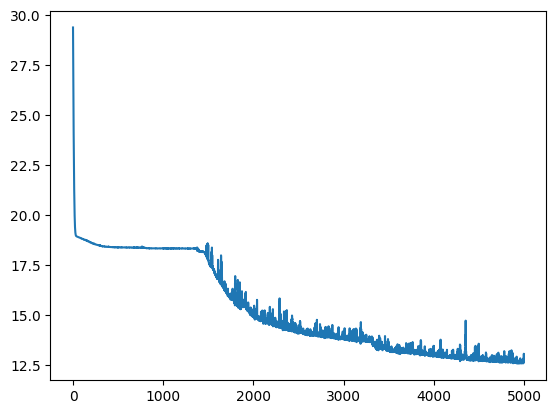

In [65]:
history = modelo.history

print('Params: ', history.params)

print('Loss: ', history.history['loss'][-1])

plt.plot(history.history['loss'])

In [66]:
previsao_na, previsao_eu, previsao_jp = modelo.predict(entradas_encoded)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [84]:
df = pd.DataFrame(
    data={
        'Previsao_NA': previsao_na.reshape(-1),
        'Real_NA': saidas_na,
        'Erro_NA': (previsao_na.reshape(-1) - saidas_na) ** 2,
        'Previsao_EU': previsao_eu.reshape(-1),
        'Real_EU': saidas_eu,
        'Erro_EU': (previsao_eu.reshape(-1) - saidas_eu) ** 2,
        'Previsao_JP': previsao_jp.reshape(-1),
        'Real_JP': saidas_jp,
        'Erro_JP': (previsao_jp.reshape(-1) - saidas_jp) ** 2
    }
)

print("Erro_NA MSE: ", df['Erro_NA'].mean())
print("Erro_EU MSE: ", df['Erro_EU'].mean())
print("Erro_JP MSE: ", df['Erro_JP'].mean())

df.head()

Erro_NA MSE:  8.137397721613917
Erro_EU MSE:  3.7329904661716866
Erro_JP MSE:  0.7745514829460008


,Previsao_NA,Real_NA,Erro_NA,Previsao_EU,Real_EU,Erro_EU,Previsao_JP,Real_JP,Erro_JP
0,11.037287,41.36,919.466938,8.207705,28.96,430.657767,2.785373,3.77,0.969490
2,10.885820,15.68,22.984158,8.094710,12.76,21.764928,2.768493,3.79,1.043477
3,11.077961,15.61,20.539378,8.238052,10.93,7.246582,2.789769,3.28,0.240326
6,9.173430,11.28,4.437635,6.818923,9.14,5.387401,2.520967,6.50,15.832704
7,8.696977,13.96,27.699415,6.464131,9.18,7.375945,2.433204,2.93,0.246806


# Modelo para vendas globais

In [98]:
def model_sequential(entradas_encoded: np.ndarray) -> Sequential:
    modelo_sequencial = Sequential(
        name="Games",
        layers=[
            Input(
                shape=(entradas_encoded.shape[1],)
            )
        ]
    )

    neuronios_camada_oculta = int((entradas_encoded.shape[1] + 3) / 2)

    modelo_sequencial.add(
        Dense(
            units = neuronios_camada_oculta,
            activation = 'sigmoid',
        )
    )
    modelo_sequencial.add(
        Dropout(
            rate = 0.2
        )
    )

    modelo_sequencial.add(
        Dense(
            units = neuronios_camada_oculta,
            activation = 'sigmoid',
        )
    )
    modelo_sequencial.add(
        Dropout(
            rate = 0.2
        )
    )

    modelo_sequencial.add(
        Dense(
            units = 1,
            activation = 'linear'
        )
    )

    modelo_sequencial.compile(
        optimizer = 'adam',
        loss = 'mse',
        metrics = ['mae']
    )

    return modelo_sequencial

def modelo_manual(entradas_encoded: np.ndarray) -> Model:
    neuronios_camada_oculta = int((entradas_encoded.shape[1] + 3) / 2)

    camada_entrada = Input(
        shape=(entradas_encoded.shape[1],)
    )

    camada_oculta_1 = Dense(
        units = neuronios_camada_oculta,
        activation = 'sigmoid',
    ) (camada_entrada)

    camada_dropout_1 = Dropout(
        rate=0.25
    ) (camada_oculta_1)

    camada_oculta_2 = Dense(
        units = neuronios_camada_oculta,
        activation = 'sigmoid',
    ) (camada_dropout_1)

    camada_dropout_2 = Dropout(
        rate=0.25
    ) (camada_oculta_2)

    camada_saida_1 = Dense(
        units = 1,
        activation = 'linear'
    ) (camada_dropout_2)

    camada_saida_2 = Dense(
        units = 1,
        activation = 'relu'
    ) (camada_dropout_2)

    modelo = Model(
        inputs=camada_entrada,
        outputs=[camada_saida_1, camada_saida_2]
    )

    modelo.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse', 'mse']
    )

    return modelo


In [99]:
sequencial = model_sequential(entradas_encoded)
manual = modelo_manual(entradas_encoded)

In [101]:
history = sequencial.fit(
    x=entradas_encoded,
    y=saidas_global,
    epochs = 5000,
    batch_size = 100,
    validation_split = 0.2,
    verbose= 2
)

Epoch 1/5000
3/3 - 1s - 268ms/step - loss: 125.5739 - mae: 8.3490 - val_loss: 11.8378 - val_mae: 3.4297
Epoch 2/5000
3/3 - 0s - 13ms/step - loss: 123.6467 - mae: 8.2559 - val_loss: 11.1588 - val_mae: 3.3294
Epoch 3/5000
3/3 - 0s - 13ms/step - loss: 122.6254 - mae: 8.1700 - val_loss: 10.5171 - val_mae: 3.2315
Epoch 4/5000
3/3 - 0s - 12ms/step - loss: 121.5916 - mae: 8.0721 - val_loss: 9.8916 - val_mae: 3.1330
Epoch 5/5000
3/3 - 0s - 13ms/step - loss: 118.5100 - mae: 7.9184 - val_loss: 9.3097 - val_mae: 3.0387
Epoch 6/5000
3/3 - 0s - 12ms/step - loss: 117.2366 - mae: 7.8415 - val_loss: 8.7470 - val_mae: 2.9446
Epoch 7/5000
3/3 - 0s - 12ms/step - loss: 117.8847 - mae: 7.8321 - val_loss: 8.1896 - val_mae: 2.8484
Epoch 8/5000
3/3 - 0s - 12ms/step - loss: 114.4628 - mae: 7.6555 - val_loss: 7.6508 - val_mae: 2.7522
Epoch 9/5000
3/3 - 0s - 12ms/step - loss: 113.5499 - mae: 7.5628 - val_loss: 7.1292 - val_mae: 2.6560
Epoch 10/5000
3/3 - 0s - 12ms/step - loss: 112.0700 - mae: 7.4686 - val_loss: 

In [100]:
hist_2 = manual.fit(
    x=entradas_encoded,
    y=[saidas_global, saidas_global],
    epochs = 5000,
    batch_size = 100,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/5000
3/3 - 1s - 399ms/step - dense_20_mse: 137.8050 - dense_21_mse: 115.6344 - loss: 253.4394 - val_dense_20_mse: 17.0733 - val_dense_21_mse: 9.2176 - val_loss: 26.2909
Epoch 2/5000
3/3 - 0s - 14ms/step - dense_20_mse: 135.4894 - dense_21_mse: 114.3854 - loss: 249.8748 - val_dense_20_mse: 16.0733 - val_dense_21_mse: 8.8044 - val_loss: 24.8776
Epoch 3/5000
3/3 - 0s - 28ms/step - dense_20_mse: 132.9461 - dense_21_mse: 114.0415 - loss: 246.9876 - val_dense_20_mse: 15.1541 - val_dense_21_mse: 8.3789 - val_loss: 23.5330
Epoch 4/5000
3/3 - 0s - 14ms/step - dense_20_mse: 131.7076 - dense_21_mse: 113.9038 - loss: 245.6114 - val_dense_20_mse: 14.2777 - val_dense_21_mse: 7.9640 - val_loss: 22.2417
Epoch 5/5000
3/3 - 0s - 13ms/step - dense_20_mse: 129.7228 - dense_21_mse: 112.9805 - loss: 242.7033 - val_dense_20_mse: 13.4512 - val_dense_21_mse: 7.5427 - val_loss: 20.9939
Epoch 6/5000
3/3 - 0s - 13ms/step - dense_20_mse: 127.9249 - dense_21_mse: 112.4423 - loss: 240.3672 - val_dense_20_mse

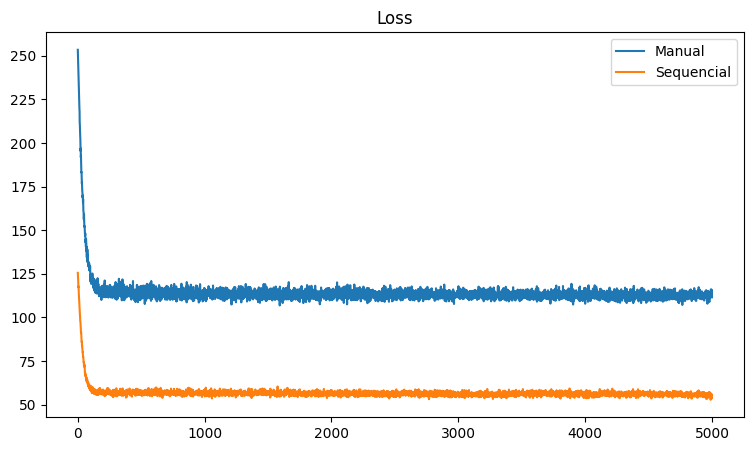

In [102]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(
    hist_2.history['loss'],
    label='Manual'
)

ax.plot(
    history.history['loss'],
    label='Sequencial'
)

ax.legend()
ax.set_title('Loss')

plt.show()